Consumer complaints on financial products & services for Bank of America from 2017 to 2023, including the dates the complaint was submitted to the CFPB and then sent to the company, the product and issue mentioned in the complaint, and the company's response.

Data Source: https://mavenanalytics.io/data-playground/financial-consumer-complaints

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Consumer_Complaints.xlsx to Consumer_Complaints (2).xlsx


In [ ]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [ ]:
if len(uploaded) > 0:
    filename = list(uploaded.keys())[0]
else:
    filename = '/mnt/data/Consumer_Complaints.xlsx'
df = pd.read_excel(filename)
df_original = df.copy()
print('Loaded file:', filename)
print('Shape:', df.shape)


Loaded file: Consumer_Complaints (2).xlsx
Shape: (62516, 12)


In [ ]:
print('Columns:', df.columns.tolist())
display(df.head(5))
display(df.info())

Columns: ['Complaint ID', 'Submitted via', 'Date submitted', 'Date received', 'State', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Company response to consumer', 'Timely response?']


,Complaint ID,Submitted via,Date submitted,Date received,State,Product,Sub-product,Issue,Sub-issue,Company public response,Company response to consumer,Timely response?
0,4848023,Referral,2021-10-24,2021-10-27,NY,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,NaN,Company has responded to the consumer and the ...,Closed with explanation,Yes
1,3621464,Web,2020-04-24,2020-04-24,FL,"Money transfer, virtual currency, or money ser...",Refund anticipation check,Lost or stolen check,NaN,Company has responded to the consumer and the ...,Closed with monetary relief,Yes
2,5818349,Web,2022-07-27,2022-07-27,CA,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,Company has responded to the consumer and the ...,Closed with explanation,Yes
3,7233015,Referral,2023-07-10,2023-07-11,CA,Credit card or prepaid card,General-purpose prepaid card,Problem getting a card or closing an account,"Trouble getting, activating, or registering a ...",NaN,In progress,NaN
4,5820224,Referral,2022-07-27,2022-07-28,VA,Credit card or prepaid card,General-purpose credit card or charge card,Closing your account,Company closed your account,Company has responded to the consumer and the ...,Closed with explanation,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62516 entries, 0 to 62515
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Complaint ID                  62516 non-null  int64         
 1   Submitted via                 62516 non-null  object        
 2   Date submitted                62516 non-null  datetime64[ns]
 3   Date received                 62516 non-null  datetime64[ns]
 4   State                         62516 non-null  object        
 5   Product                       62516 non-null  object        
 6   Sub-product                   62509 non-null  object        
 7   Issue                         62516 non-null  object        
 8   Sub-issue                     51658 non-null  object        
 9   Company public response       60341 non-null  object        
 10  Company response to consumer  62516 non-null  object        
 11  Timely response?            

None

Drop exact duplicates and report missingness

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
missing_summary = df.isna().sum().sort_values(ascending=False)
missing_summary

,0
Sub-issue,10858
Company public response,2175
Timely response?,1494
Sub-product,7
Date received,0
Date submitted,0
Submitted via,0
Complaint ID,0
Issue,0
Product,0


Detection of relevant columns and mapping

In [ ]:
cols = df.columns.tolist()
import re
def find_col(patterns):
    for p in patterns:
        for c in cols:
            if re.search(p, c, flags=re.IGNORECASE):
                return c
    return None

date_received_col = find_col([r'date\s*received', r'date\s*recvd', r'date\s*received'])
date_submitted_col = find_col([r'date\s*submitted', r'date\s*submitted'])
date_sent_col = find_col([r'date\s*sent', r'date\s*sent\s*to', r'date\s*sent\s*to\s*company'])
product_col = find_col([r'^product$'])
issue_col = find_col([r'^issue$'])
company_col = find_col([r'company'])
response_col = find_col([r'company\s*response', r'company\s*response\s*to'])
timely_col = find_col([r'timely\s*response', r'timely'])
narrative_col = find_col([r'narrative'])

detected = {
    'date_received_col': date_received_col,
    'date_submitted_col': date_submitted_col,
    'date_sent_col': date_sent_col,
    'product_col': product_col,
    'issue_col': issue_col,
    'company_col': company_col,
    'response_col': response_col,
    'timely_col': timely_col,
    'narrative_col': narrative_col
}
detected


{'date_received_col': 'Date received',
 'date_submitted_col': 'Date submitted',
 'date_sent_col': None,
 'product_col': 'Product',
 'issue_col': 'Issue',
 'company_col': 'Company public response',
 'response_col': 'Company response to consumer',
 'timely_col': 'Timely response?',
 'narrative_col': None}

Parse date columns and create time features

In [ ]:
if date_received_col is None:
    raise ValueError('No Date Received column detected; cannot continue time analysis.')
df[date_received_col] = pd.to_datetime(df[date_received_col], errors='coerce')
if date_sent_col is not None:
    df[date_sent_col] = pd.to_datetime(df[date_sent_col], errors='coerce')
if date_submitted_col is not None:
    df[date_submitted_col] = pd.to_datetime(df[date_submitted_col], errors='coerce')

df = df[df[date_received_col].notna()].reset_index(drop=True)
df['Year'] = df[date_received_col].dt.year
df['Month'] = df[date_received_col].dt.month
df['MonthName'] = df[date_received_col].dt.month_name()
df['Quarter'] = df[date_received_col].dt.to_period('Q')
df['DayOfWeek'] = df[date_received_col].dt.day_name()
display(df[[date_received_col,'Year','Month','MonthName','Quarter','DayOfWeek']].head())


,Date received,Year,Month,MonthName,Quarter,DayOfWeek
0,2021-10-27,2021,10,October,2021Q4,Wednesday
1,2020-04-24,2020,4,April,2020Q2,Friday
2,2022-07-27,2022,7,July,2022Q3,Wednesday
3,2023-07-11,2023,7,July,2023Q3,Tuesday
4,2022-07-28,2022,7,July,2022Q3,Thursday


Timeliness, delays, and narrative features

In [ ]:
if timely_col is not None:
    df['TimelyFlag'] = df[timely_col].replace({'Yes':1,'No':0}).map(lambda x: np.nan if x not in (0,1) else x)
else:
    df['TimelyFlag'] = np.nan

if date_sent_col is not None:
    df['ResponseDelayDays'] = (df[date_sent_col] - df[date_received_col]).dt.days
else:
    df['ResponseDelayDays'] = np.nan

if narrative_col is not None:
    df['HasNarrative'] = df[narrative_col].notna().astype(int)
    df['NarrativeLength'] = df[narrative_col].fillna('').str.len()
else:
    df['HasNarrative'] = 0
    df['NarrativeLength'] = 0

display(df[['TimelyFlag','ResponseDelayDays','HasNarrative','NarrativeLength']].describe().T)


/tmp/ipython-input-3823198648.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimelyFlag'] = df[timely_col].replace({'Yes':1,'No':0}).map(lambda x: np.nan if x not in (0,1) else x)


,count,mean,std,min,25%,50%,75%,max
TimelyFlag,61022.0,0.960621,0.194497,0.0,1.0,1.0,1.0,1.0
ResponseDelayDays,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HasNarrative,62516.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
NarrativeLength,62516.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Monthly aggregation and seasonal decomposition

/tmp/ipython-input-2390193726.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.groupby(pd.Grouper(key=date_received_col, freq='M')).size().rename('Count').reset_index()
/tmp/ipython-input-2390193726.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = monthly.set_index(date_received_col).asfreq('M').fillna(0)


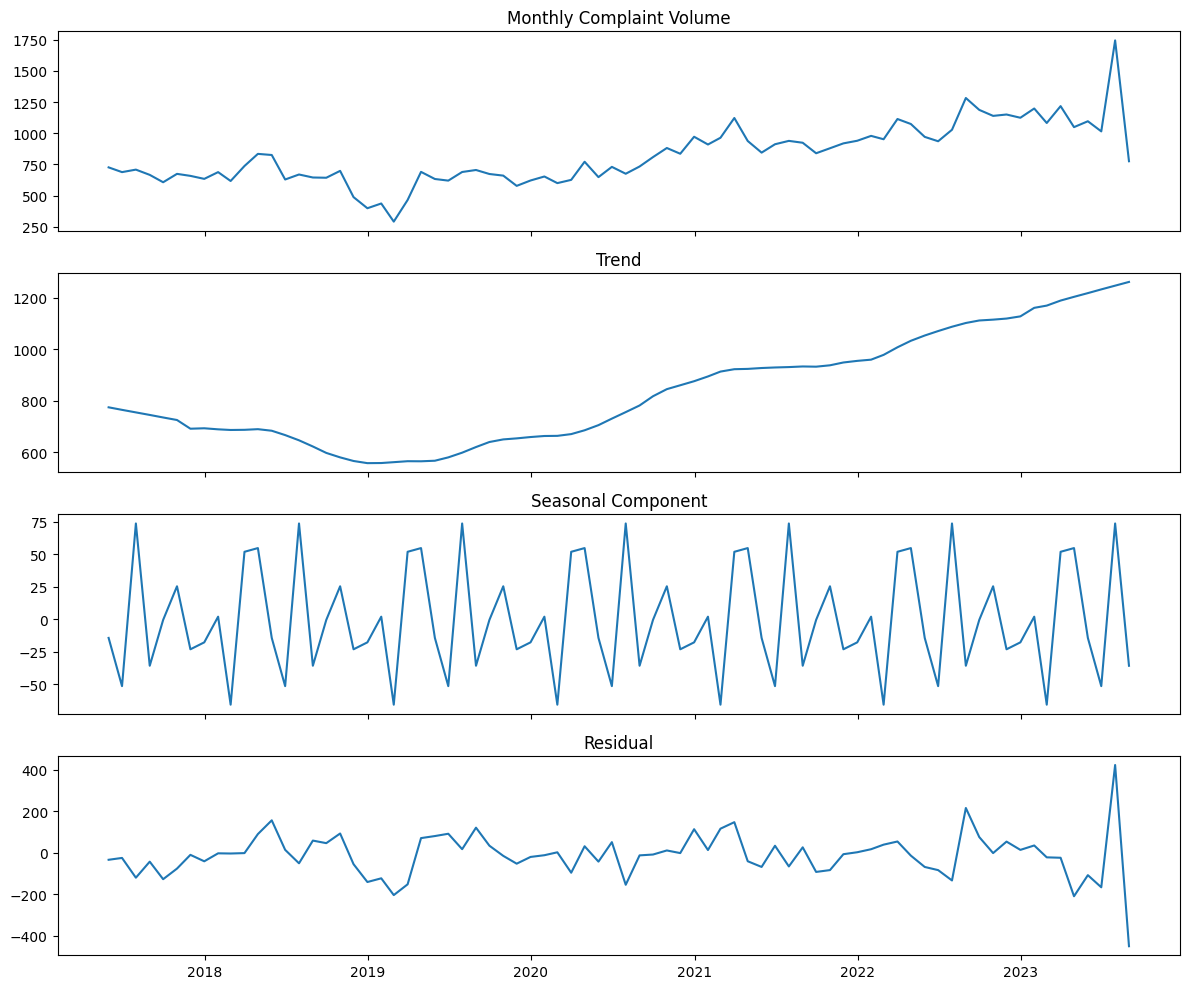

,Count
Date received,
2021-09-30,840
2021-10-31,880
2021-11-30,919
2021-12-31,940
2022-01-31,979
2022-02-28,952
2022-03-31,1114
2022-04-30,1074
2022-05-31,971


In [ ]:
monthly = df.groupby(pd.Grouper(key=date_received_col, freq='M')).size().rename('Count').reset_index()
monthly = monthly.set_index(date_received_col).asfreq('M').fillna(0)
result = seasonal_decompose(monthly['Count'], model='additive', period=12, extrapolate_trend='freq')
fig, axes = plt.subplots(4,1, figsize=(12,10), sharex=True)
axes[0].plot(monthly.index, monthly['Count']); axes[0].set_title('Monthly Complaint Volume')
axes[1].plot(result.trend); axes[1].set_title('Trend')
axes[2].plot(result.seasonal); axes[2].set_title('Seasonal Component')
axes[3].plot(result.resid); axes[3].set_title('Residual')
plt.tight_layout()
plt.show()
display(monthly.tail(24))


Top products and top issues per product

In [ ]:
if product_col is not None:
    product_counts = df.groupby(product_col).size().rename('TotalComplaints').reset_index().sort_values('TotalComplaints', ascending=False)
    top_products = product_counts.head(10)
else:
    product_counts = pd.DataFrame()
    top_products = pd.DataFrame()

if product_col is not None and issue_col is not None:
    prod_issue = df.groupby([product_col, issue_col]).size().rename('IssueCount').reset_index().sort_values(['IssueCount'], ascending=False)
    top_issues_by_product = prod_issue.groupby(product_col).head(5)
else:
    prod_issue = pd.DataFrame()
    top_issues_by_product = pd.DataFrame()

display(top_products)
display(top_issues_by_product.head(20))


,Product,TotalComplaints
0,Checking or savings account,24814
1,Credit card or prepaid card,16197
2,"Credit reporting, credit repair services, or o...",7710
5,Mortgage,6601
4,"Money transfer, virtual currency, or money ser...",3453
3,Debt collection,2736
8,Vehicle loan or lease,633
6,"Payday loan, title loan, or personal loan",333
7,Student loan,39


,Product,Issue,IssueCount
4,Checking or savings account,Managing an account,15109
24,Credit card or prepaid card,Problem with a purchase shown on your statement,4415
40,"Credit reporting, credit repair services, or o...",Incorrect information on your report,4145
0,Checking or savings account,Closing an account,2953
76,Mortgage,Trouble during payment process,2827
5,Checking or savings account,Opening an account,2725
8,Checking or savings account,Problem with a lender or other company chargin...,2493
55,"Money transfer, virtual currency, or money ser...",Fraud or scam,1951
75,Mortgage,Struggling to pay mortgage,1904
16,Credit card or prepaid card,Getting a credit card,1867


How complaints are typically resolved

In [ ]:
if response_col is not None:
    resolution = df.groupby(response_col).size().rename('Count').reset_index().sort_values('Count', ascending=False)
else:
    resolution = pd.DataFrame()

if company_col is not None and response_col is not None:
    company_response = df.groupby([company_col, response_col]).size().rename('Count').reset_index().sort_values(['Count'], ascending=False)
    top_company_responses = company_response.groupby(company_col).head(3)
else:
    company_response = pd.DataFrame()
    top_company_responses = pd.DataFrame()

display(resolution)
display(top_company_responses.head(20))


,Company response to consumer,Count
1,Closed with explanation,41044
2,Closed with monetary relief,14697
3,Closed with non-monetary relief,5273
4,In progress,1494
0,Closed,8


,Company public response,Company response to consumer,Count
11,Company has responded to the consumer and the ...,Closed with explanation,40557
12,Company has responded to the consumer and the ...,Closed with monetary relief,14524
13,Company has responded to the consumer and the ...,Closed with non-monetary relief,5230
7,Company believes the complaint provided an opp...,Closed with explanation,6
2,Company believes it acted appropriately as aut...,Closed with explanation,5
8,Company believes the complaint provided an opp...,Closed with monetary relief,5
4,Company believes the complaint is the result o...,Closed with explanation,3
5,Company believes the complaint is the result o...,Closed with monetary relief,3
0,Company believes complaint caused principally ...,Closed with explanation,2
10,Company disputes the facts presented in the co...,Closed with explanation,2


Untimely responses: by product, issue, company and t-test

In [ ]:
untimely_df = df[df['TimelyFlag']==0].copy()
late_by_product = untimely_df.groupby(product_col).size().rename('LateCount').reset_index().sort_values('LateCount', ascending=False) if product_col is not None else pd.DataFrame()
late_by_issue = untimely_df.groupby(issue_col).size().rename('LateCount').reset_index().sort_values('LateCount', ascending=False) if issue_col is not None else pd.DataFrame()
late_by_company = untimely_df.groupby(company_col).size().rename('LateCount').reset_index().sort_values('LateCount', ascending=False) if company_col is not None else pd.DataFrame()

timely_delay = df[df['TimelyFlag']==1]['ResponseDelayDays'].dropna()
untimely_delay = df[df['TimelyFlag']==0]['ResponseDelayDays'].dropna()
ttest_result = None
if len(timely_delay)>0 and len(untimely_delay)>0:
    ttest_result = stats.ttest_ind(timely_delay, untimely_delay, equal_var=False)

display(late_by_product.head(10))
display(late_by_issue.head(10))
display(late_by_company.head(10))
print('T-test result (timely vs untimely response delays):', ttest_result)


,Product,LateCount
0,Checking or savings account,867
1,Credit card or prepaid card,689
2,"Credit reporting, credit repair services, or o...",475
3,Debt collection,173
4,"Money transfer, virtual currency, or money ser...",140
7,Vehicle loan or lease,33
5,Mortgage,16
6,"Payday loan, title loan, or personal loan",10


,Issue,LateCount
20,Managing an account,497
18,Incorrect information on your report,322
35,Problem with a purchase shown on your statement,197
2,Attempts to collect debt not owed,118
4,Closing an account,116
23,Opening an account,107
32,Problem with a credit reporting company's inve...,99
33,Problem with a lender or other company chargin...,99
12,Fraud or scam,80
17,Improper use of your report,80


,Company public response,LateCount
3,Company has responded to the consumer and the ...,2211
2,Company believes the complaint provided an opp...,3
0,Company believes complaint caused principally ...,2
1,Company believes it acted appropriately as aut...,1


T-test result (timely vs untimely response delays): None


Narrative length vs delay, yearly trends, company median delay

In [ ]:
corr_df = df[['NarrativeLength','ResponseDelayDays','TimelyFlag']].dropna()
corr_matrix = corr_df.corr() if not corr_df.empty else pd.DataFrame()
yearly_trend = df.groupby('Year').size().rename('Count').reset_index()
company_median_delay = df.groupby(company_col)['ResponseDelayDays'].median().reset_index().sort_values('ResponseDelayDays', ascending=False) if company_col is not None else pd.DataFrame()

display(corr_matrix)
display(yearly_trend)
display(company_median_delay.head(20))


""


,Year,Count
0,2017,5369
1,2018,7884
2,2019,7075
3,2020,8943
4,2021,11133
5,2022,12936
6,2023,9176


,Company public response,ResponseDelayDays
0,Company believes complaint caused principally ...,NaN
1,Company believes it acted appropriately as aut...,NaN
2,Company believes the complaint is the result o...,NaN
3,Company believes the complaint provided an opp...,NaN
4,Company disputes the facts presented in the co...,NaN
5,Company has responded to the consumer and the ...,NaN


Visualization

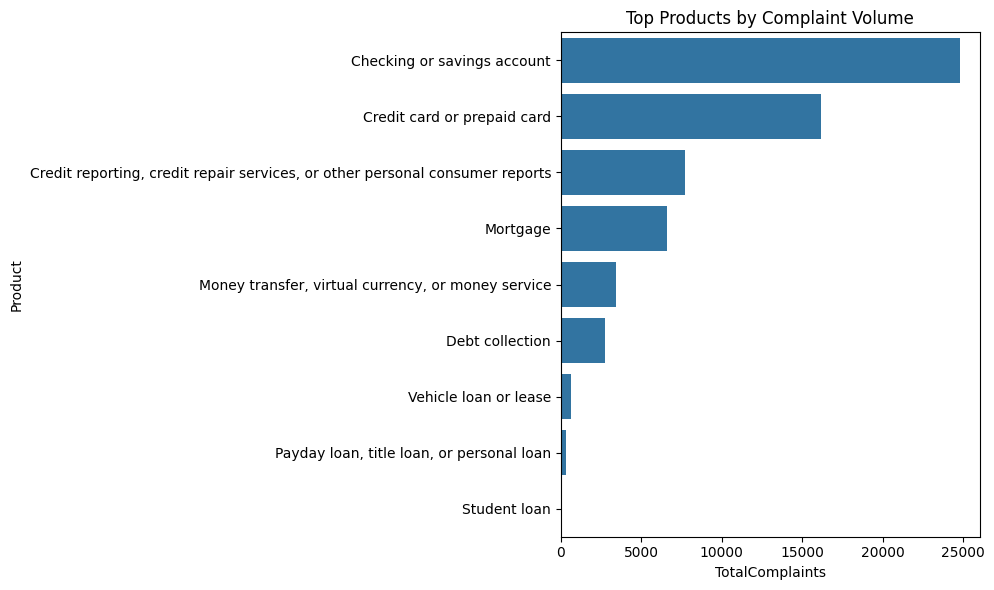

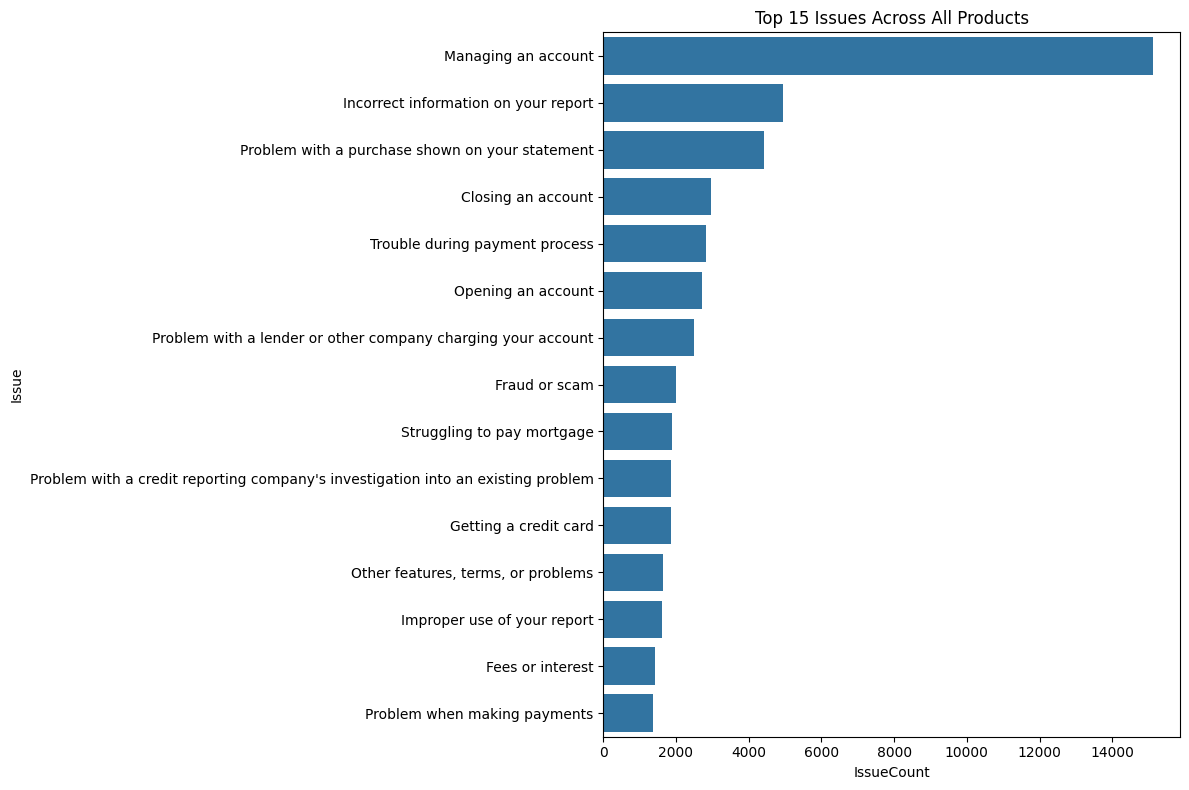

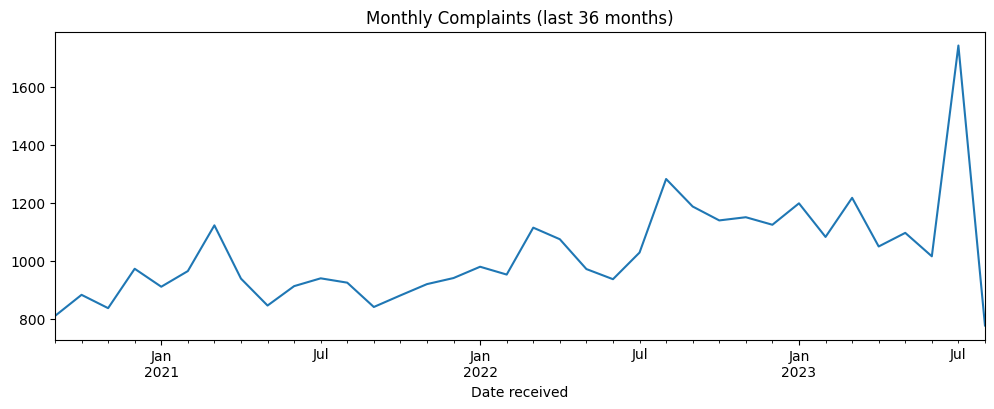

Saved plots to /mnt/data/consumer_complaint_analysis_outputs


In [ ]:
output_folder = '/mnt/data/consumer_complaint_analysis_outputs'
os.makedirs(output_folder, exist_ok=True)

plt.figure(figsize=(10,6))
if not top_products.empty:
    sns.barplot(data=top_products, x='TotalComplaints', y=product_col)
    plt.title('Top Products by Complaint Volume')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder,'top_products.png'))
    plt.show()

plt.figure(figsize=(12,8))
if not prod_issue.empty:
    top_issues = prod_issue.groupby(issue_col)['IssueCount'].sum().reset_index().sort_values('IssueCount', ascending=False).head(15)
    sns.barplot(data=top_issues, x='IssueCount', y=issue_col)
    plt.title('Top 15 Issues Across All Products')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder,'top_issues.png'))
    plt.show()

if not monthly.empty:
    monthly.tail(36).plot(figsize=(12,4), legend=False)
    plt.title('Monthly Complaints (last 36 months)')
    plt.savefig(os.path.join(output_folder,'monthly_tail.png'))
    plt.show()

print('Saved plots to', output_folder)


Export Summary for reporting

In [ ]:
if not product_counts.empty:
    product_counts.to_csv(os.path.join(output_folder,'product_counts.csv'), index=False)
if not prod_issue.empty:
    prod_issue.to_csv(os.path.join(output_folder,'product_issue_counts.csv'), index=False)
if not resolution.empty:
    resolution.to_csv(os.path.join(output_folder,'resolution_counts.csv'), index=False)
if not late_by_product.empty:
    late_by_product.to_csv(os.path.join(output_folder,'late_by_product.csv'), index=False)
if not company_median_delay.empty:
    company_median_delay.to_csv(os.path.join(output_folder,'company_median_delay.csv'), index=False)

print('Saved CSV summaries to', output_folder)


Saved CSV summaries to /mnt/data/consumer_complaint_analysis_outputs
